In [1]:
import os
import glob
import copy

import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns
import psignifit as ps
import _pickle as pkl

from psignifit import getSigmoidHandle as getSig
import analyze2p.objects.neurometric as nm

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
import importlib

In [3]:
import analyze2p.plotting as pplot

In [4]:
src_dir = os.path.join('/n/coxfs01/behavior-data/threeport')
morph_dir = os.path.join(src_dir, 'processed/morphs')
fit_dir = os.path.join(morph_dir, 'fits')

In [5]:
fig_dir = os.path.join(fit_dir, 'figures')
if not os.path.exists(os.path.join(fig_dir)):
    os.makedirs(os.path.join(fig_dir))


In [6]:
datafile = os.path.join(morph_dir, 'data_summaries.pkl')
with open(datafile, 'rb') as f:
    ddict = pkl.load(f, encoding='latin1')
counts = ddict['counts']
pass_animals = ddict['pass_animals']
data = ddict['data']
all_animals = counts['animalid'].unique()
print('%i/%i animals pass with criterion 0.70' % (len(pass_animals), len(all_animals)))

10/13 animals pass with criterion 0.70


# Load fits

In [7]:
max_x = counts['morphlevel'].max()
criterion=0.70
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']


In [8]:
#prefix = 'fits_m22-gauss'
prefix = 'fits_L23-gauss'
aggr_fpath = glob.glob(os.path.join(fit_dir, 'aggr_%s*.pkl' % prefix))[0]

In [9]:
fit_dir

'/n/coxfs01/behavior-data/threeport/processed/morphs/fits'

In [10]:
fpaths = glob.glob(os.path.join(fit_dir, '%s*.pkl' % prefix))
print(len(fpaths))
results={}
d_=[]
for fn in fpaths:
    animalid = os.path.splitext(os.path.split(fn)[-1])[0].split(prefix)[-1][1:]
    with open(fn, 'rb') as f:
        res = pkl.load(f)
    res['options']['sigmoidHandle'] = getSig.getSigmoidHandle(res['options'])
    res['options']['priors'] = ps.priors.getStandardPriors(res['data'], res['options'])
    
    df_ = pd.DataFrame(res['Fit'], index=param_names, columns=[animalid]).T
    try:
        #  Value at which function reaches at_pc correct (scaled w/ lapse and guess rate)
        thr = ps.getThreshold(res, 0.5, 0)[0]
        # Slope at given stimulus level
        slp = ps.getSlope(res, ps.getThreshold(res, 0.5, 1)[0]) 
    except Exception as e:
        thr=None
        slp=None
    [thr_0,CI0] = ps.getThreshold(res,0.25,1)
    [thr_1,CI1] = ps.getThreshold(res,0.75,1)
    jnd = (thr_1-thr_0)/2.
    df_['thr_25'] = thr_0
    df_['thr_75'] = thr_1
    df_['jnd'] = jnd
    df_['slope'] = slp
    df_['thr_scaled'] = thr
    #df_['thr_unscaled'] = ps.getThreshold(res, 0.5, 1)[0]
    df_['animalid'] = animalid
    d_.append(df_)
    results[animalid] = res
FITS = pd.concat(d_, axis=0)

13


<IPython.core.display.Javascript object>


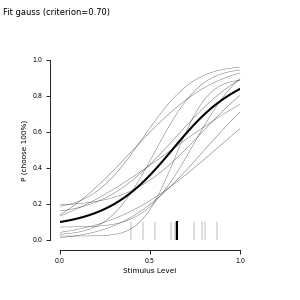

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


AG10 [0.79 1.01 0.   0.19 0.07]
AG2 [0.64 0.48 0.11 0.02 0.  ]
AG4 [0.8  1.17 0.   0.   0.  ]
AG6 [0.87 1.49 0.   0.02 0.06]
AG8 [0.74 0.69 0.   0.07 0.  ]
AG9 [0.62 1.83 0.   0.   0.  ]
AN4 [0.46 0.73 0.03 0.17 0.  ]
AN5 [0.64 1.03 0.   0.14 0.  ]
AN6 [0.39 1.21 0.02 0.   0.  ]
AN7 [0.53 0.66 0.05 0.03 0.  ]
/n/coxfs01/behavior-data/threeport/processed/morphs/fits/figures fits_L23-gauss_curves


In [11]:
%matplotlib notebook
max_x=1
mean_color='k'
mean_lw = 2
thresh_height=0.1
npoints=50
opts = nm.default_options(yesno=True)
sigmoid_=opts['sigmoidName']
fitvs=[]

fig, ax = pl.subplots(figsize=(4,4))
for animalid, res in results.items():
    if animalid not in pass_animals:
        continue
    print(animalid, res['Fit'].round(2))
    ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=0.25, 
                            plotAsymptote=False,
                            thresh_height=thresh_height, fontSize=6, labelSize=7,
                            npoints=npoints, extrapolLength=0, )
    fh = getSig.getSigmoidHandle(opts)
    xv, fv = nm.fit_sigmoid(res['Fit'], fh, xmin=0, xmax=max_x)
    fitvs.append(fv)
    
fitvs = np.array(fitvs)
mean_fit = np.mean(fitvs, axis=0)

ax.plot(xv, mean_fit, mean_color, lw=mean_lw)
mean_thr = FITS[FITS.animalid.isin(pass_animals)]['threshold'].mean()
ax.plot([mean_thr, mean_thr], [0, thresh_height], color=mean_color, lw=mean_lw)
ax.set_box_aspect(1)

# formatting
ax.set_xlim([0, max_x])
ax.set_xticks(np.linspace(0, max_x, 3))
pl.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8)
sns.despine(trim=True, offset=10)
ax.set_ylabel('P (choose 100%)')
fig.text(0.01, 0.95, 'Fit %s (criterion=%.2f)' % (sigmoid_, criterion), fontsize=8)

figname = '%s_curves' % prefix
pl.savefig(os.path.join(fig_dir, '%s.svg' % figname))
print(fig_dir, figname)

In [17]:
# This messes up plotting
# %matplotlib notebook
# fig, axn =pl.subplots(2,5)
# for ax, animalid in zip(axn.flat, pass_animals):
#     res = results[animalid]
#     ps.psigniplot.plotMarginal(res, 0, prior=True, axisHandle=ax)
#     ax.set_title(animalid)
#     ax.set_box_aspect(1)
# pl.subplots_adjust(wspace=0.5, hspace=0.5)

<IPython.core.display.Javascript object>


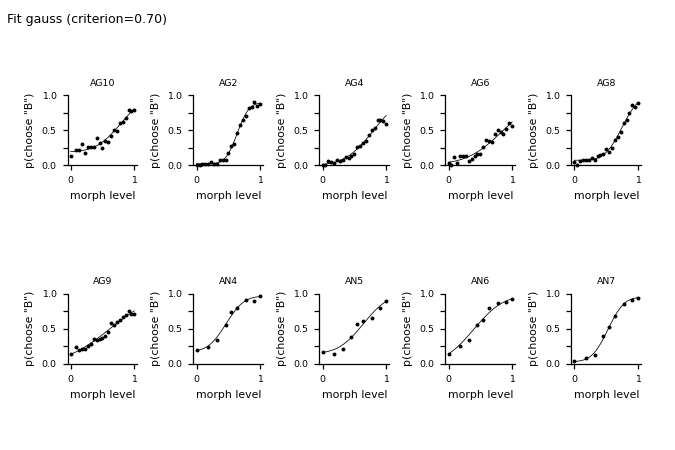

AG10 [0.79 1.01 0.   0.19 0.07]
AG2 [0.64 0.48 0.11 0.02 0.  ]
AG4 [0.8  1.17 0.   0.   0.  ]
AG6 [0.87 1.49 0.   0.02 0.06]
AG8 [0.74 0.69 0.   0.07 0.  ]
AG9 [0.62 1.83 0.   0.   0.  ]
AN4 [0.46 0.73 0.03 0.17 0.  ]
AN5 [0.64 1.03 0.   0.14 0.  ]
AN6 [0.39 1.21 0.02 0.   0.  ]
AN7 [0.53 0.66 0.05 0.03 0.  ]
/n/coxfs01/behavior-data/threeport/processed/morphs/fits/figures fits_L23-gauss_curves_each_animal


In [50]:
fig, axn = pl.subplots(2, 5, figsize=(6,4), dpi=150)
ai = 0 
for animalid, res in results.items():
    if animalid not in pass_animals:
        continue
    ax=axn.flat[ai]
    print(animalid, res['Fit'].round(2))
    ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=True, 
                            yLabel='p(choose "B")', xLabel='morph level', 
                            lineWidth=0.5,  
                            plotAsymptote=False,dataColor='k', 
                            scale_marker=False, markersize=3,
                            thresh_height=0, fontSize=6, labelSize=7,
                            npoints=npoints, extrapolLength=0, tufteAxis=True)
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_yticklabels([round(i, 1) if i in [0, 0.5, 1.] else ''
                       for i in np.linspace(0, 1, 5)])
    ax.set_box_aspect(1)
    ax.set_title(animalid, fontsize=6)
    ai+=1
pl.subplots_adjust(left=0.1, bottom=0.1, right=0.95, wspace=0.8, hspace=0.3)

fig.text(0.01, 0.95, 'Fit %s (criterion=%.2f)' % (sigmoid_, criterion), fontsize=8)

figname = '%s_curves_each_animal' % prefix
pl.savefig(os.path.join(fig_dir, '%s.svg' % figname))
print(fig_dir, figname)

In [48]:
np.linspace(0, 1, 5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

### Fits

In [12]:
passdf = FITS[FITS.animalid.isin(pass_animals)].copy()

In [13]:
passdf['thr_75']

AG10    0.993263
AG2     0.736500
AG4     1.042611
AG6     1.176594
AG8     0.886371
AG9     0.992956
AN4     0.611866
AN5     0.854066
AN6     0.642379
AN7     0.661737
Name: thr_75, dtype: float64

In [14]:
n_rats=len(pass_animals)

<IPython.core.display.Javascript object>


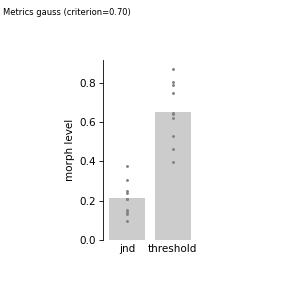

/n/coxfs01/behavior-data/threeport/processed/morphs/fits/figures fits_L23-gauss_params
         jnd  threshold
count  10.00      10.00
mean    0.21       0.65
std     0.09       0.16
min     0.10       0.39
25%     0.14       0.55
50%     0.21       0.64
75%     0.25       0.78
max     0.38       0.87


In [52]:
%matplotlib notebook

plot_params =['jnd', 'threshold'] # ['threshold', 'jnd']
fig, ax = pl.subplots(figsize=(4,4))

for ai, param in enumerate(plot_params):
    ax.bar(x=ai, height=passdf[param].mean(), color=[0.8]*3, zorder=-100)
    ax.scatter([ai]*n_rats, passdf[param].values, color=[0.5]*3, s=3, zorder=100)
ax.set_xticks(np.arange(0, len(plot_params)))
ax.set_xticklabels([str(p) for p in plot_params], rotation=0)
ax.tick_params(which='both', axis='x', size=0)

ax.set_box_aspect(2)
#ax.set_ylim([0,1])
ax.set_ylabel('morph level')
sns.despine(bottom=True, offset=2)
pl.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8)

fig.text(0.01, 0.95, 'Metrics %s (criterion=%.2f)' % (sigmoid_, criterion), fontsize=8)

figname = '%s_params' % prefix
pl.savefig(os.path.join(fig_dir, '%s.svg' % figname))
print(fig_dir, figname)

print(passdf[plot_params].describe().round(2))
    

In [20]:
import scipy.stats as spstats

In [21]:
def dprime_from_data(data):
    df = pd.DataFrame(data,columns=['morphlevel', 'n_chooseB', 'n_trials'])
    df['fraction_chooseB'] = df['n_chooseB']/df['n_trials']
    df['n_chooseA'] = (df['n_trials'] - df['n_chooseB'])/df['n_trials']
    df['fraction_chooseA'] = df['n_chooseA']/df['n_trials']

    df.loc[df['fraction_chooseB']==0, 'fraction_chooseB'] = 0.001
    df.loc[df['fraction_chooseA']==0, 'fraction_chooseA'] = 0.001

    df['zHit'] = spstats.norm.ppf(df['fraction_chooseB'])
    df['zFA'] = spstats.norm.ppf(df['fraction_chooseA'])

    df['dprime'] = None
    for i in np.arange(1, len(df)):
        dv = df.iloc[i]['zHit'] - df.iloc[i-1]['zHit'] 
        df.loc[i, 'dprime'] = dv #.append(df)
    df['cumsum']=df['dprime'].cumsum()
    dprime_B = float(df[df['morphlevel']==1]['zHit']) \
                - float(df[df['morphlevel']==0]['zFA'] )
    
    return df, dprime_B

In [22]:
dprimes={}
df_list=[]
animalid = 'AG2'
for animalid, res in results.items():
    df, dprime_B = dprime_from_data(res['data'])
    df['animalid'] = animalid
    dprimes.update({animalid: dprime_B})
    df_list.append(df)
d_df = pd.concat(df_list, axis=0)
    

In [223]:
for c in ['dprime', 'cumsum']:
    d_df[c]=d_df[c].astype(float)


<IPython.core.display.Javascript object>


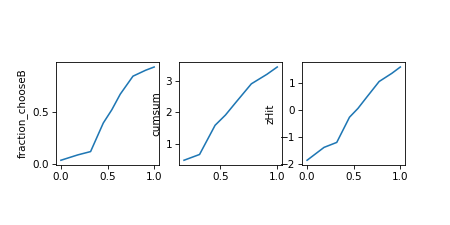

In [224]:
%matplotlib notebook
y_vars = ['fraction_chooseB', 'cumsum', 'zHit']
fig, axn = pl.subplots(1, 3, figsize=(6,3))

for ax, y_var in zip(axn, y_vars):
    ax.plot(df['morphlevel'].values, df[y_var].values)
    ax.set_ylabel(y_var)
    ax.set_box_aspect(1)
# ax=axn[1]
# ax.plot(df['morphlevel'], df['cumsum'])
# for ax in axn.flat:
#     ax.set_box_aspect(1)

<IPython.core.display.Javascript object>


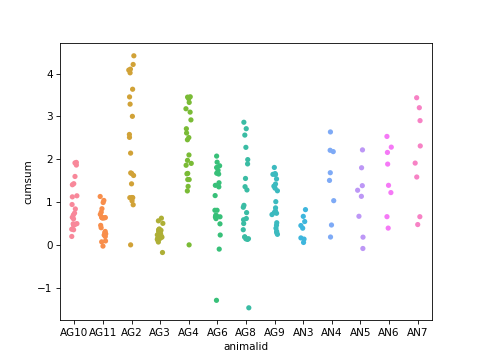

<AxesSubplot:xlabel='animalid', ylabel='cumsum'>

In [225]:
fig, ax =pl.subplots()
sns.stripplot(x='animalid', y='cumsum', data=d_df, ax=ax)

In [17]:
passdf.describe()

,threshold,width,lambda,gamma,eta,thr_25,thr_75,jnd,slope,thr_scaled
count,10.000000,10.000000,1.000000e+01,10.000000,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.648820,1.029184,2.129707e-02,0.064895,1.294949e-02,0.437806,0.859834,0.422028,1.333275,0.628394
std,0.155314,0.415254,3.492307e-02,0.075946,2.730078e-02,0.160362,0.192422,0.170279,0.520185,0.151818
min,0.393935,0.476903,5.479165e-09,0.000083,3.009425e-08,0.145490,0.611866,0.195559,0.717321,0.404760
25%,0.549806,0.702459,2.718414e-07,0.005220,8.685806e-08,0.331968,0.680428,0.288051,1.053439,0.543602
50%,0.641199,1.017267,1.549867e-04,0.025292,2.018010e-07,0.487116,0.870219,0.417141,1.108196,0.637179
75%,0.775970,1.200642,3.152967e-02,0.126226,5.241508e-07,0.564925,0.993186,0.492336,1.674328,0.716402
max,0.870924,1.829436,1.072818e-01,0.191586,6.530542e-02,0.602329,1.176594,0.750180,2.395963,0.861824


In [248]:
import pingouin as pg

In [250]:
posthoc='fdr_bh'
sts = pg.pairwise_ttests(data=plotdf, dv='per_correct', between='type',
                   parametric=False, padjust=posthoc, effsize='eta-square')
sts

NameError: name 'plotdf' is not defined

In [53]:
for (a, o, s), g in data.groupby(['animalid', 'objectid', 'session']):
    df_ = g.sort_values(by=['time'])
    df_['trial'] = np.arange(0, len(df_))
    data.loc[df_.index, 'trial'] = df_['trial']
    

In [54]:
default_views = data[(data['size']==40) & (data['depth_rotation']==0)
                    & (data.animalid.isin(pass_animals))].copy()

In [100]:
default_views[(default_views.morphlevel==0) & (default_views.animalid=='AG10')]['outcome'].unique()


array(['success', 'failure'], dtype=object)

In [90]:
ign = ['name', 'light_position', 'x_rotation', 'outcome', 'duration', 'trial',
       'outcome_time', 'response', 'response_time','suffix', 'time',
       'sessionid', 'objectid']
cols = [c for c in data.columns if c not in ign]
d_=[]
for (a, s, m), g \
    in default_views.groupby(['animalid', 'session', 'morphlevel']):
    n_trials = len(g)
    n_success = len(g[g['outcome']=='success'])
    pc_ = n_success/float(n_trials)
    mean_rt = g['response_time'].mean()
    
    df_ = g[cols].drop_duplicates().reset_index(drop=True)
    df_['perc_correct'] = pc_
    df_['mean_rt'] = mean_rt
    df_['n_trials'] = n_trials
    d_.append(df_)
scores = pd.concat(d_)
scores

,depth_rotation,no_feedback,object,pos_x,pos_y,rotation,size,session,animalid,cohort,phase,portmap,morphlevel,perc_correct,mean_rt,n_trials
0,0,False,morph,0.0,0.0,0.0,40.0,20160723,AG10,AG,7,0,2,0.843750,0.727317,32
0,0,False,morph,0.0,0.0,0.0,40.0,20160723,AG10,AG,7,0,3,0.774194,0.776850,31
0,0,False,morph,0.0,0.0,0.0,40.0,20160723,AG10,AG,7,0,4,0.593750,0.949025,32
0,0,False,morph,0.0,0.0,0.0,40.0,20160723,AG10,AG,7,0,5,0.843750,0.763649,32
0,0,False,morph,0.0,0.0,0.0,40.0,20160723,AG10,AG,7,0,6,0.656250,0.911680,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,False,morph,0.0,0.0,0.0,40.0,20180608,AN7,AN,7,1,12,0.933333,0.943403,15
0,0,False,morph,0.0,0.0,0.0,40.0,20180608,AN7,AN,7,1,14,1.000000,0.774907,8
0,0,False,morph,0.0,0.0,0.0,40.0,20180608,AN7,AN,7,1,17,0.866667,0.835577,15
0,0,False,morph,0.0,0.0,0.0,40.0,20180608,AN7,AN,7,1,20,1.000000,0.780049,12


In [101]:
anchors = scores[(scores['morphlevel'].isin([0, 22]))].copy()
anchors.head()

,depth_rotation,no_feedback,object,pos_x,pos_y,rotation,size,session,animalid,cohort,phase,portmap,morphlevel,perc_correct,mean_rt,n_trials
0,0,False,1,0.0,0.0,0.0,40.0,20160726,AG10,AG,7,0,0,0.800000,0.714012,25
0,0,False,2,0.0,0.0,0.0,40.0,20160726,AG10,AG,7,0,22,0.880000,0.897410,25
0,0,False,1,0.0,0.0,0.0,40.0,20160727,AG10,AG,7,0,0,0.791667,0.686334,24
0,0,False,2,0.0,0.0,0.0,40.0,20160727,AG10,AG,7,0,22,0.791667,0.825729,24
0,0,False,1,0.0,0.0,0.0,40.0,20160813,AG10,AG,7,0,0,0.953488,0.537166,43


In [102]:
object_colors={0: 'r', 22: 'b'}

<IPython.core.display.Javascript object>


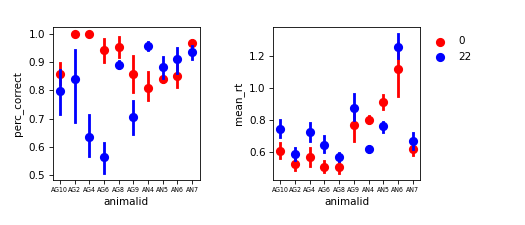

In [103]:

fig, axn = pl.subplots(1,2, figsize=(7,3))
for ax, metric in zip(axn.flat, ['perc_correct', 'mean_rt']):
    sns.pointplot(x='animalid', y=metric, data=anchors, ax=ax,
                 join=False, hue='morphlevel', palette=object_colors)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)
    ax.legend_.remove()
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.8, wspace=0.5, bottom=0.2)


In [125]:
# default_views[default_views.morphlevel.isin([0, 22])][['animalid', 'objectid', 'response', 'outcome', 'portmap']].drop_duplicates()

choice_map =  {0: {'chooseA': 'Announce_AcquirePort3', 
                 'chooseB': 'Announce_AcquirePort1'},
               1: {'chooseA': 'Announce_AcquirePort1',
                 'chooseB': 'Announce_AcquirePort3'}}
class_a, class_b = (0, 22)

In [199]:
import math
# def xget_hits_and_fas_for_session(g, class_a=0, class_b=22, portmap=0):
#     a_trials = g[g.morphlevel==class_a].copy()
#     b_trials = g[g.morphlevel==class_b].copy()
#     n_showed_a = len(a_trials)
#     n_showed_b = len(b_trials)
#     # N times rat says "A" when shown "A"
#     n_said_a_a = len(a_trials[a_trials.response==choice_map[portmap]['chooseA']])
#     # N times rat says "A" when shown "B"
#     n_said_a_b = len(b_trials[b_trials.response==choice_map[portmap]['chooseA']])
    
#     hits = n_said_a_a / n_showed_a
#     fas = n_said_a_b / n_showed_b
    
#     df_ = pd.Series({'p_hit': hits, 'p_fa': fas, 
#                      'num_a': n_showed_a, 'num_b': n_showed_b})
    
#     return df_

def get_hits_and_fas_for_session(g, class_a=0, class_b=22, portmap=0):
    a_trials = g[g.morphlevel==class_a].copy()
    b_trials = g[g.morphlevel==class_b].copy()
    n_showed_a = len(a_trials)
    n_showed_b = len(b_trials)
    # N times rat says "A" when shown "A"
    n_said_a_a = len(a_trials[a_trials.response==choice_map[portmap]['chooseA']])
    # N times rat says "A" when shown "B"
    n_said_a_b = len(b_trials[b_trials.response==choice_map[portmap]['chooseA']])
    
    hits = n_said_a_a / n_showed_a
    misses = n_showed_a - n_said_a_a
    crs = n_showed_b - n_said_b_b
    fas = n_said_a_b / n_showed_b
    
    df_ = SDT(hits, misses, fas, crs)
    df_['num_a'] = n_showed_a
    df_['num_b'] = n_showed_b
    #pd.Series(df_)
    
    return pd.Series(df_)

def SDT(hits, misses, fas, crs):
    
    """ returns a dict with d-prime measures given hits, misses, false alarms, and correct rejections"""
    Z=spstats.norm.ppf
    # Floors an ceilings are replaced by half hits and half FA's
    half_hit = 0.5 / (hits + misses)
    half_fa = 0.5 / (fas + crs)

    # Calculate hit_rate and avoid d' infinity
    hit_rate = hits / (hits + misses)
    if hit_rate == 1: 
        hit_rate = 1 - half_hit
    if hit_rate == 0: 
        hit_rate = half_hit

    # Calculate false alarm rate and avoid d' infinity
    fa_rate = fas / (fas + crs)
    if fa_rate == 1: 
        fa_rate = 1 - half_fa
    if fa_rate == 0: 
        fa_rate = half_fa
    # Return d', beta, c and Ad'
    out = {}
    out['d'] = Z(hit_rate) - Z(fa_rate)
    out['beta'] = math.exp((Z(fa_rate)**2 - Z(hit_rate)**2) / 2)
    out['c'] = -(Z(hit_rate) + Z(fa_rate)) / 2
    out['Ad'] = spstats.norm.cdf(out['d'] / math.sqrt(2))
        
    return(out)

In [161]:
anchor_trials= default_views[default_views.morphlevel.isin([class_a, class_b])].copy()


In [205]:
s_list=[]
for (a, s), g in anchor_trials.groupby(['animalid', 'session']):
    port_ = float(g['portmap'].unique())
    try:
        sdt_vals = get_hits_and_fas_for_session(g, class_a=class_a, class_b=class_b,
                                                portmap=port_)
    except ZeroDivisionError:
        print(a, s)
        continue
    sdt_vals['animalid'] = a
    sdt_vals['session'] = s
    s_list.append(sdt_vals)
sdt_df = pd.concat(s_list, axis=1).T


In [206]:
sdt_df

,d,beta,c,Ad,num_a,num_b,animalid,session
0,1.38745,11.874109,1.783387,0.836722,25.0,25.0,AG10,20160726
1,1.158422,6.95737,1.67452,0.793643,24.0,24.0,AG10,20160727
2,1.888343,14.170407,1.403958,0.909104,43.0,42.0,AG10,20160813
3,1.89102,23.287152,1.664658,0.909414,41.0,40.0,AG10,20160814
4,1.333476,8.111578,1.569802,0.827136,39.0,39.0,AG10,20160815
...,...,...,...,...,...,...,...,...
63,1.862629,84.690913,2.383195,0.906094,234.0,246.0,AN7,20180522
64,2.184796,452.041951,2.798327,0.938813,632.0,667.0,AN7,20180523
65,2.437214,644.314406,2.653926,0.957589,644.0,657.0,AN7,20180524
66,1.919273,243.454228,2.863026,0.91263,521.0,540.0,AN7,20180607


In [210]:
cols = [k for k in sdt_df.columns if k not in ['animalid', 'session']]
for c in cols:
    sdt_df[c] = sdt_df[c].astype(float)

In [211]:
# sdt_df['z_hit'] = spstats.norm.ppf(sdt_df['p_hit'])
# sdt_df['z_fa'] = spstats.norm.ppf(sdt_df['p_fa'])
# sdt_df['d_prime'] = sdt_df['z_hit'] - sdt_df['z_fa']
# sdt_df

In [232]:
df_from_datamat = d_df[d_df.animalid.isin(pass_animals)]
# fig, ax =pl.subplots()


<IPython.core.display.Javascript object>


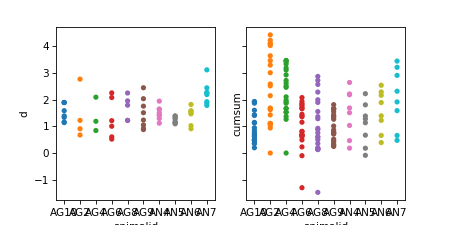

<AxesSubplot:xlabel='animalid', ylabel='cumsum'>

In [234]:
fig, axn =pl.subplots(1, 2, figsize=(6,3), sharex=True, sharey=True)
ax=axn[0]
sns.stripplot(x='animalid', y='d', data=sdt_df, ax=ax, jitter=False)
ax=axn[1]
sns.stripplot(x='animalid', y='cumsum', data=df_from_datamat, ax=ax, jitter=False)

In [239]:
sdt_df.groupby(['animalid']).mean().reset_index().describe().round(2)

,d,beta,c,Ad,num_a,num_b
count,10.00,10.00,10.00,10.00,10.00,10.00
mean,1.51,63.63,1.73,0.84,166.15,165.21
std,0.28,113.65,0.96,0.04,189.80,189.39
min,1.24,4.10,0.68,0.79,12.80,12.80
25%,1.38,9.86,0.76,0.81,15.98,15.83
50%,1.44,14.07,1.62,0.84,32.94,33.06
75%,1.52,63.65,2.72,0.85,353.03,345.19
max,2.23,374.66,2.92,0.94,448.12,455.88


In [237]:
df_from_datamat.groupby(['animalid']).mean().reset_index().describe().round(2)

,morphlevel,n_chooseB,n_trials,fraction_chooseB,n_chooseA,fraction_chooseA,zHit,zFA,dprime,cumsum
count,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
mean,0.52,183.01,370.09,0.43,0.57,0.01,-0.29,-2.69,0.21,1.48
std,0.02,176.98,318.47,0.13,0.13,0.00,0.48,0.20,0.12,0.58
min,0.50,29.35,102.00,0.26,0.38,0.00,-0.92,-2.95,0.08,0.94
25%,0.50,41.59,117.46,0.33,0.50,0.00,-0.75,-2.85,0.10,1.02
50%,0.52,72.34,166.80,0.43,0.57,0.00,-0.20,-2.72,0.17,1.28
75%,0.54,358.75,634.94,0.50,0.67,0.01,-0.02,-2.55,0.31,1.94
max,0.54,437.67,887.44,0.62,0.74,0.01,0.44,-2.41,0.43,2.41


# Bias?

In [62]:
means_by_rat = anchors.groupby(['animalid', 'objectid', 'morphlevel', 'portmap']).mean().reset_index()

In [63]:
passdf

,threshold,width,lambda,gamma,eta,thr_25,thr_75,jnd,slope,thr_scaled,animalid
AG10,0.786510,1.008403,5.479165e-09,0.191586,6.530542e-02,0.579757,0.993263,0.206753,1.052124,0.694081,AG10
AG2,0.638721,0.476903,1.072818e-01,0.022069,5.957917e-07,0.540941,0.736500,0.097780,2.395963,0.656548,AG2
AG4,0.803273,1.167329,1.686528e-07,0.001704,8.926838e-08,0.563935,1.042611,0.239338,1.122363,0.802514,AG4
AG6,0.870924,1.490850,3.450953e-08,0.015769,6.418791e-02,0.565255,1.176594,0.305670,0.866424,0.861824,AG6
AG8,0.744350,0.692684,5.814075e-07,0.072002,2.042160e-07,0.602329,0.886371,0.142021,1.758245,0.723843,AG8
AG9,0.617866,1.829436,6.401648e-07,0.000083,3.092284e-07,0.242776,0.992956,0.375090,0.717321,0.617809,AG9
AN4,0.461828,0.731785,3.427200e-02,0.172509,1.993860e-07,0.311789,0.611866,0.150038,1.422580,0.412848,AN4
AN5,0.643678,1.026131,3.093332e-04,0.144301,4.319882e-08,0.433290,0.854066,0.210388,1.094028,0.577374,AN5
AN6,0.393935,1.211747,2.330269e-02,0.000413,8.605462e-08,0.145490,0.642379,0.248445,1.057381,0.404760,AN6
AN7,0.527120,0.656573,4.780348e-02,0.028514,3.009425e-08,0.392502,0.661737,0.134617,1.846319,0.532344,AN7


In [64]:
d1 = means_by_rat.sort_values(by='animalid')\
            [means_by_rat['objectid']=='1'].reset_index(drop=True)
d2 = means_by_rat.sort_values(by='animalid')\
            [means_by_rat['objectid']=='2'].reset_index(drop=True)
diffdf = pd.DataFrame({'response_time': d2['mean_rt']-d1['mean_rt'],
              'accuracy': d2['perc_correct'] - d1['perc_correct'],
              'animalid': d2['animalid'],
            'portmap': d2['portmap']}
            )

resdf = pd.merge(passdf, diffdf, on=['animalid'])

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


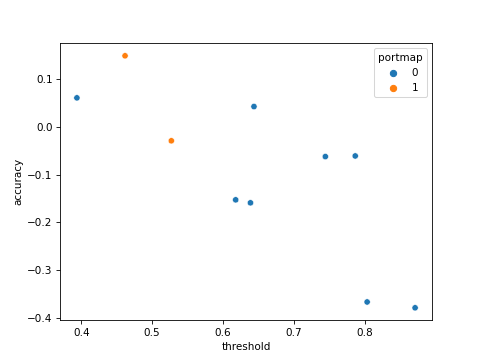

<AxesSubplot:xlabel='threshold', ylabel='accuracy'>

In [65]:
fig, ax = pl.subplots()
sns.scatterplot(x='threshold', y='accuracy', data=resdf, hue='portmap', ax=ax)